# Project 2 - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import scipy 
from iminuit import Minuit
import lightgbm as lgb

In [17]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, log_loss, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [5]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Add grid
mpl.rc('axes', grid=True)

# Set custom color cycle
custom_colors= ['dodgerblue', 'red', 'limegreen', 'orange', 'orchid', 'black', 'slategrey', 
                'navy', 'magenta', 'forestgreen', 'lightblue', 'maroon', 'gold', 'lightcoral', 
                'mediumseagreen', 'darkorange', 'darkviolet', 'dimgray', 'darkblue', 'darkred',]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Set inside tickmarks
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [6]:
save_plots = False

# Exercise 1a

In [7]:
data = pd.read_csv('earning_potential_train_test.txt', delimiter = ',', header=0, index_col=None)
data.sort_values(by='earning', inplace=True)

# Create target array  
# Dummification of Earning Column (1 - >50K, 0- <=50K)
data['earning'] = pd.get_dummies(data['earning'], drop_first=True, dtype=int)

In [8]:
data

,age,education,gender,hours-per-week,earning
0,39,13,0,40,0
2801,17,7,1,25,0
2802,35,10,0,60,0
2803,33,14,0,20,0
2804,25,12,1,40,0
...,...,...,...,...,...
773,37,11,1,24,1
2546,24,10,0,70,1
1493,53,9,0,35,1
1492,45,9,0,40,1


In [9]:
# Find the number of individuals with high/low earnings in the full data set
N_high = np.sum(data['earning'] == True)
N_low = np.sum(data['earning'] == False)
ratio = N_high / N_low

# Print results
print(f'There are {len(data)} individuals included in the full data set.')
print(f'Higher income earners: {N_high}')
print(f'Lower income earners: {N_low}')
print(f'The ratio of higher to lower income earners is {ratio:.2f}.')

There are 4500 individuals included in the full data set.
Higher income earners: 1091
Lower income earners: 3409
The ratio of higher to lower income earners is 0.32.


In [10]:
# Split the data into a training and test set
train = pd.concat([data.iloc[:int(N_low/2)], data.iloc[N_low:int(N_low + N_high/2 + 1)]])

# Find the number of individuals with high/low earnings in the full data set
N_high_train = np.sum(train['earning'] == True)
N_low_train = np.sum(train['earning'] == False)
ratio_train = N_high_train / N_low_train

# Print results
print(f'There are {len(train)} individuals included in the train data set.')
print(f'Higher income earners: {N_high_train}')
print(f'Lower income earners: {N_low_train}')
print(f'The ratio of higher to lower income earners is {ratio_train:.2f}.')


There are 2250 individuals included in the train data set.
Higher income earners: 546
Lower income earners: 1704
The ratio of higher to lower income earners is 0.32.


In [11]:
# Split the data into a training and test set
test = pd.concat([data.iloc[int(N_low/2): int(N_low)], data.iloc[int(N_low + N_high/2 + 1):]])

# Find the number of individuals with high/low earnings in the full data set
N_high_test = np.sum(test['earning'] == True)
N_low_test = np.sum(test['earning'] == False)
ratio_test = N_high_test / N_low_test

# Print results
print(f'There are {len(test)} individuals included in the test data set.')
print(f'Higher income earners: {N_high_test}')
print(f'Lower income earners: {N_low_test}')
print(f'The ratio of higher to lower income earners is {ratio_test:.2f}.')

There are 2250 individuals included in the test data set.
Higher income earners: 545
Lower income earners: 1705
The ratio of higher to lower income earners is 0.32.


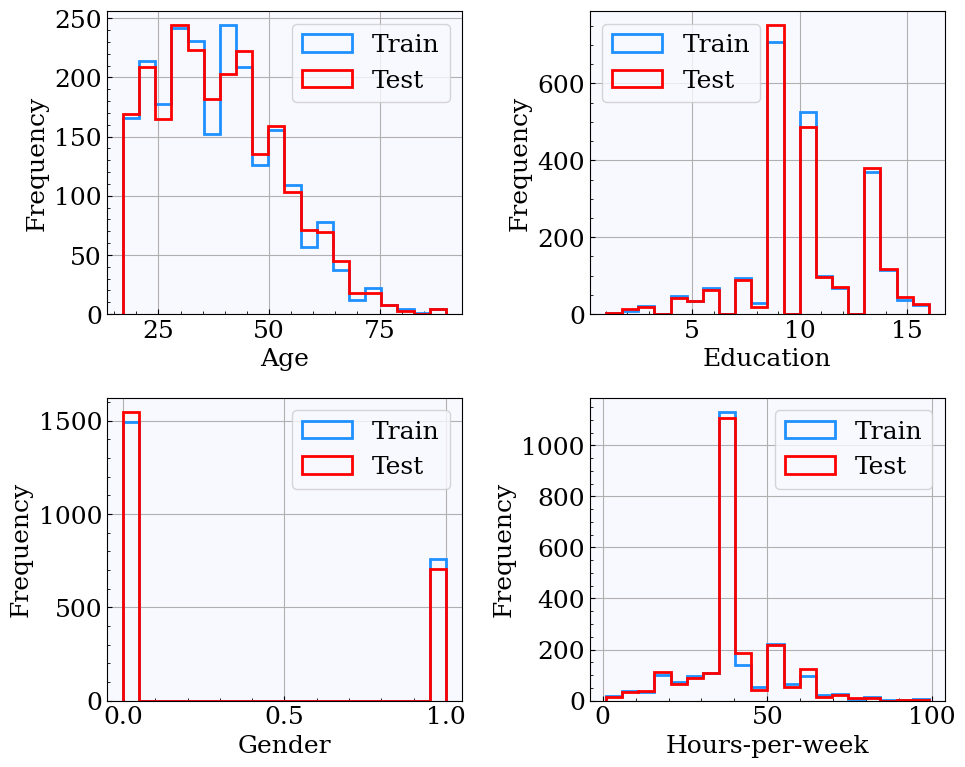

In [12]:
# Plot the distribution of the four variables for the training and test set 

fig, ax = plt.subplots(2, 2, figsize=(10, 8))

# Age
ax[0, 0].hist(train['age'], bins=20, histtype='step', label='Train', lw=2)
ax[0, 0].hist(test['age'], bins=20, histtype='step', label='Test', lw=2)

ax[0, 0].set_xlabel('Age')
ax[0, 0].set_ylabel('Frequency')
ax[0, 0].legend()

# Education
ax[0, 1].hist(train['education'], bins=20, histtype='step', label='Train', lw=2)
ax[0, 1].hist(test['education'], bins=20, histtype='step', label='Test', lw=2)

ax[0, 1].set_xlabel('Education')
ax[0, 1].set_ylabel('Frequency')
ax[0, 1].legend()

# Gender
ax[1, 0].hist(train['gender'], bins=20, histtype='step', label='Train', lw=2)
ax[1, 0].hist(test['gender'], bins=20, histtype='step', label='Test', lw=2)

ax[1, 0].set_xlabel('Gender')
ax[1, 0].set_ylabel('Frequency')
ax[1, 0].legend()

# Hours-per-week
ax[1, 1].hist(train['hours-per-week'], bins=20, histtype='step', label='Train', lw=2)
ax[1, 1].hist(test['hours-per-week'], bins=20, histtype='step', label='Test', lw=2)

ax[1, 1].set_xlabel('Hours-per-week')
ax[1, 1].set_ylabel('Frequency')
ax[1, 1].legend()

fig.tight_layout()

if save_plots:
    plt.savefig('earning_potential_train_test.png', dpi=300)

In [13]:
# Separating the independent and target variable on both data sets
x_train = train.drop(columns = ['earning'], axis = 1).values
y_train = train['earning'].values
x_test = test.drop(columns = ['earning'], axis = 1).values
y_test = test['earning'].values

# Shuffling the data
np.random.seed(42)
idx = np.arange(len(x_train))
np.random.shuffle(idx)
x_train = x_train[idx]
y_train = y_train[idx]

idx = np.arange(len(x_test))
np.random.shuffle(idx)
x_test = x_test[idx]
y_test = y_test[idx]

Accuracy: 0.8013333333333333


Text(0.5, 1.0, 'ROC curve')

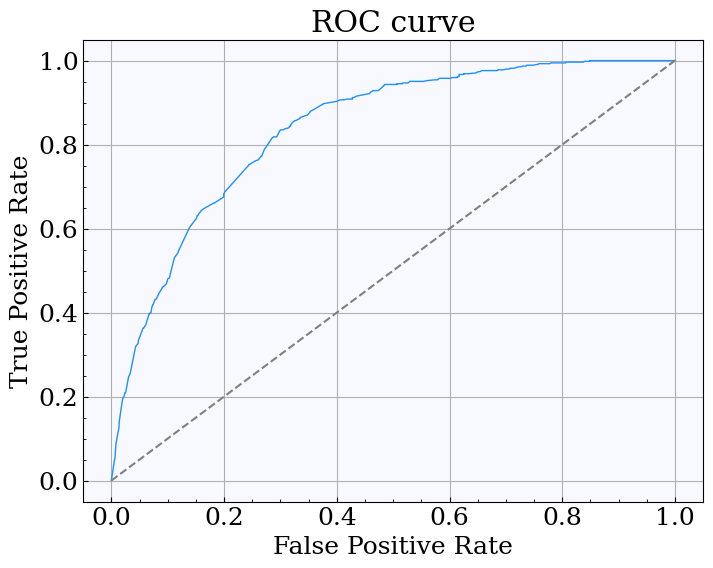

In [43]:
from sklearn.ensemble import AdaBoostClassifier

# Create the AdaBoost classifier
bdt = AdaBoostClassifier(n_estimators=150, learning_rate=0.05)

# Train the classifier  
model = bdt.fit(x_train, y_train)

# Test the classifier
y_pred_binary = model.predict(x_test)
y_pred = model.predict_proba(x_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_binary))

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

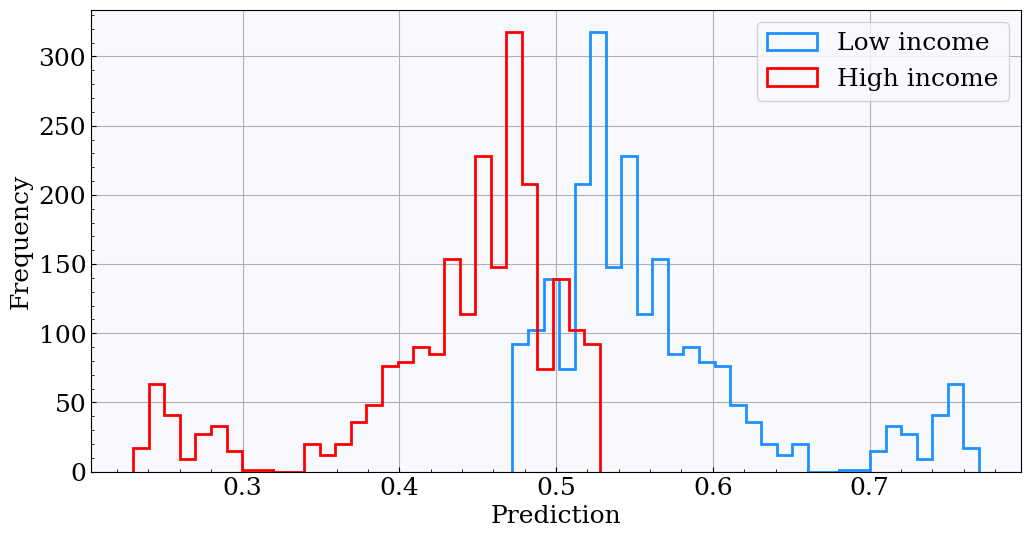

In [44]:
# Plot the prediction for the test set

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.hist(y_pred[:,0], bins=30, histtype='step', lw=2, label='Low income')
ax.hist(y_pred[:,1], bins=30, histtype='step', lw=2, label='High income')

ax.set_xlabel('Prediction')
ax.set_ylabel('Frequency')
ax.legend()


# Exercise 1b